<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Introduction and Data Preparation</h1> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Binary Classification](#binary-classification)  
&nbsp;&nbsp;&nbsp;[Data Description](#description)    
[Load Raw Data](#load-data)  
[Inspect and Clean Data](#inspect)  
[Build Derived Features](#derived-features)  
[Dummy Variables](#dummy-variables)  
[Data Exploration](#exploration)  
[Create Test/Train Split and Save Data](#save-data)



# Introduction <a class="anchor" id="introduction"></a>
Measuring poverty in developing countries is a complex undertaking. Money-metric poverty measurements require the calculation of national or international poverty lines, and the collection and analysis of detailed data on households’ income or consumption. Due to their complexity and cost, such surveys are conducted infrequently in many low-income countries, and typically on relatively small samples of the population.

In this project, we conduct an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The primary objective of the project is to answer the following questions:
* How well would machine algorithms perform when given the task to identify the poor in a given population?
* Where, when and how could or should we apply them for that specific purpose?

A secondary objective is to make machine learning techniques more accessible to researchers, data scientists, and statisticians in developing countries by generating training materials and building capacity. Machine learning tools and methods can be implemented at a low cost to many different purposes and data types. By making their use more technically accessible, the project will contribute to improving the data producers and decision makers' toolkit in developing countries.

## Binary Classification <a class="anchor" id="binary-classification"></a>

The goal of this project is to use the survey data to build a model that predicts if a household is poor or non-poor. This problem is considered a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) problem. The machine learning models we will introduce in this project all attempt to use the survey data to "learn" the rules that determine the answer to the question "Is this household under the poverty level?". 

As an example, let's say we have only two questions on a survey, with answers that range from 1 to 10. We give the survey to 100 households, half of which are poor and the other half non-poor. In the figure below, we plot the survey responses and mark poor households with a blue cross and non-poor households with a red circle. If we use a straight line as the decision boundary, we can do a pretty good job of separating the markers, with poor households above the line and non-poor below the line. The goal of a binary classification algorithm would be to find the formula for this line so we can apply it to new households that we don't already know are poor or not.

<img alt="binary classification diagram" src="img/binary-classification.png" width="75%"/>

Notice that the decision boundary in the figure is a pretty good fit, but there are a few exceptions of red circles above the line and blue crosses below the line. If we were to use this decision boundary as our classifier, these points would be incorrectly classified. We may not be able to find a function that perfectly separates the points, but we want to train our binary classifier to find the line that give us the lowest amount of error. 

In the actual datasets we will be working with in this project, there are hundreds of questions, and the relationships between them are more complex. The binary classification algorithms we will explore each have unique ways of learning these relationships. At the end of this project, we will be able to compare how each one performs on this type of data.

To prepare the data for binary classification, we need to ensure it is in a format suitable for the machine learning tools we plan to use. This means transforming each survey response into a set of independent variables, or a [feature vector](https://en.wikipedia.org/wiki/Feature_vector), that corresponds to the dependent variable of poverty.

## Binary Classification Algorithms
In this project, we will apply and compare 10 different binary classification algorithms to poverty datasets from Malawi and Indonesia. There will be two Jupyter Notebooks associated with each algorithm: In the first, we introduce the classifier and apply it to the Malawi dataset, beginning with a simple subset of features to highlight basic considerations and parameters of the model. We then apply it to the full set of features, including sample weights when possible, and explore different methods for feature selection and parameter tuning to increase performance. In the second notebook, we apply the classifier to the Indonesia dataset. Here we explore considerations for how to deal with unbalanced data and examine how the classifer performns on a somewhat different set of features in the context of another country. In each notebook we will also use the results of the classifier to estimate the country's poverty level.

The algorithms we will explore in this project include:
1. Logistic Regression
1. Linear Discriminant Analysis (LDA)
1. K-Nearest Neighbors
1. Naive Bayes
1. Support Vector Machines
1. Decision Trees
1. Random Forests
1. XGBoost
1. Multilayer Perceptron
1. Deep Learning

This data preparation notebook should be run first to ensure the necessary files are generated for the datasets that will be loaded into each algorithm notebook. Since we will be progressively introducing new concepts throughout this project and comparing results along the way, we recommend running each notebook in the sequence above.

## Data Description <a class="anchor" id="description"></a>

In this notebook, we introduce the poverty datasets that will be used for the project and go through the process of cleaning and transform the data into a format suitable for applying the machine learining algorithms. This notebook should be run first from the project directory to produce the processed files we will use in following notebooks.

### Raw data overview
The data for this project includes data and metadata from surveys in two countries -- Indonesia and Malawi. For each country, you will find:
* The survey questionnaire(s)
* Two Stata (version 14) data files: household and individual. These data contain a subset of the full survey dataset
* An Excel file, providing a list of variables in the data files
* Two text files (output of the “codebook” Stata command, providing a list of variables with some metadata.
 
### Stata file contents
The Stata data files contain:
* The label variable (the binary variable to be predicted), named “poor”. This is just a poor/non-poor dummy variable. Note: poverty is calculated at the household level; either all or none of one same household member is/are poor.
* The sample weights (the objective is to “predict” poverty taking into account these sample weights. Variable `wta_hh` contains the household weight; variable `wta_pop` contains the population weight (household weight * household size). These are probability weights (the sum of `wta_pop` gives us the extrapolated population of the country).
* The file that will be used as training/test set is the `household.dta` file.
* The `individual.dta` file contains variables on each household member. The file is provided to allow us to create additional variables to be added to the `household.dta` file. The variable `hhsize` (household size) is one such derived variable, already calculated. We will probably use this to generate new variables to possibly improve the accuracy of the model.

### Filtering Consumable Feaures
The `household.dta` file contains a series of variables whose name starts with `cons_`. These are variables derived from the expenditure module of the survey. It indicates whether a household consumed/purchased a specific item or not. Any reported value > 0 for an item was transformed into code 1; 0 otherwise.  

*IMPORTANT*: Since one objective of this project is to design light survey questionnaires that would allow accurate poverty prediction, we want to be selective in the list of variables we use in the final model. What we would like to do is optimize a model using the variables we find useful (including new derived variables), under the constraint that no more than 50 of the `cons_` variables will be used. Some quick analysis of these `cons_` variables should make it possible to make a selection prior to tuning the models.

## Load the Raw Data <a class="anchor" id="load-data"></a>

First, we load a few essential modules used in notebook. We have developed several utility functions in the `load_data.py` file located in the `src/data` directory that will be used throughout this project for convenience.

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd
from pandas.io.stata import StataReader

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data
from features import process_features

## Inspect and Clean Data <a class="anchor" id="inspect"></a>

We'll start with loading the data for Malawi. The Indonesia data is in a similar format, so we can create some helpful functions that will apply to both countries.

The survey data we are using for this project has mostly been cleaned and put in a useful format in the Stata files, but there are still a few issues that we deal with here for illustrative purposes. The issues we identified only affect a few entries and we are only processing the data once, so we can directly fix these in the same function we build to load the data below.

These issues include:

1. There appears to be some conflict in how pandas and Stata deal with categoricals, so we have to load the data in without converting categoricals and load the labels separately using pandas StataReader. The issue was with several entries in the `ind_educ09` column of the Malawi individual data -- there are duplicate labels for Primary and Secondary school choices: "CHURCH/MISSION SCHOOL" and "ISLAMIC SCHOOL", which raises an error when pandas attempts to convert categoricals. We manually fix this in the function below using the `update_education` parameter.

1. There are a small number of entries in the Malawi household data that do not match any of the labels. These occur in the `hld_cooking`, `hld_toiletshr`, and `hld_bednet` columns and are probably data entry errors. Since this only affects 5 rows in the dataset, we simply drop these records using the `drop_unlabeled` parameter.

1. A small number of records in the Malawi household dataset have missing values in one or more columns (< 10). Since this is a very small number, we drop these records using the `drop_minornans` parameter.

In [2]:
def load_stata_file(filepath, 
                    index_cols, 
                    update_education=False, 
                    drop_minornans=False, 
                    drop_unlabeled=False):
    """ Load data and metadata from Stata file"""
    data = pd.read_stata(filepath, convert_categoricals=False).set_index(index_cols)

    with StataReader(filepath) as reader:
        reader.value_labels()
            
        mapping = {col: reader.value_label_dict[t] for col, t in 
                   zip(reader.varlist, reader.lbllist)
                   if t in reader.value_label_dict}
        
        # manually update some specific columns
        # in the Malawi dataset
        if update_education and 'ind_educ09' in mapping:
            mapping['ind_educ09'][13] = "Primary - " + mapping['ind_educ09'][13]
            mapping['ind_educ09'][14] = "Primary - " + mapping['ind_educ09'][14]
            
            mapping['ind_educ09'][23] = "Secondary - " + mapping['ind_educ09'][23]
            mapping['ind_educ09'][24] = "Secondary - " + mapping['ind_educ09'][24]
        
        data.replace(mapping, inplace=True)
        
        # convert the categorical variables into
        # the category type
        for c in data.columns:
            if c in mapping:
                data[c] = data[c].astype('category')
                        
        # drop records with only a few nans
        if drop_minornans: 
            nan_counts = (data.applymap(pd.isnull)
                          .sum(axis=0)
                          .sort_values(ascending=False))
            nan_cols = nan_counts[(nan_counts > 0) & (nan_counts < 10)].index.values
            data = data.dropna(subset=nan_cols)
        # drop unlabeled categorical values
        def find_unlabeled(x):
            if x.name in mapping.keys():
                return [val if (val in mapping[x.name].values() or pd.isnull(val)) 
                        else 'UNLABELED' for val in x]
            else:
                return x
            
        data = data.apply(find_unlabeled)
        data = data[~data.applymap(lambda x: x == "UNLABELED").any(axis=1)]
        
        # read the actual questions that were asked for reference
        questions = reader.variable_labels()
        
    return data, questions

First we'll load the Malawi data using the function above

In [3]:
# Load Malawi household data
filepath = load_data.MWI_HOUSEHOLD
mwi_hhold, mwi_hhold_questions = load_stata_file(filepath, 
                                                 ['hid'], 
                                                 drop_minornans=True, 
                                                 drop_unlabeled=True)

s = 'Malawi household data has {:,} rows and {:,} columns'
print(s.format(mwi_hhold.shape[0], mwi_hhold.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_hhold.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_hhold.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_hhold.head()

Malawi household data has 12,244 rows and 346 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,wta_hh,wta_pop,der_hhsize,poor,hld_dwelloccu,hld_dwelltype,hld_walls,hld_roof,hld_floor,hld_rooms,...,com_weeklymrkt,com_postoffice,com_publicphone,com_distprimary,com_classrooms,com_schoolelec,com_medicines,com_clinic,com_distclinic,com_bank
hid,,,,,,,,,,,,,,,,,,,,,
101010160009,126.560097,759.360596,6,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160033,126.560097,506.240387,4,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160060,126.560097,1265.600952,10,Poor,Owned,Semi-Permanent,Burnt bricks,Grass,Smoothed mud,6,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160068,126.560097,1139.040894,9,Poor,Owned,Traditional,Mud,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160069,126.560097,126.560097,1,Non-poor,Owned,Traditional,Mud brick,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No


In [4]:
filepath = load_data.MWI_INDIVIDUAL
mwi_indiv, mwi_indiv_questions = load_stata_file(filepath, 
                                                 ['hid', 'iid'], 
                                                 update_education=True)

s = 'Malawi individual data has {:,} rows and {:,} columns'
print(s.format(mwi_indiv.shape[0], mwi_indiv.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_indiv.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_indiv.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_indiv.head()

Malawi individual data has 56,211 rows and 42 columns
Percent poor: 52.4% 	Percent non-poor: 47.6%


ind_sex         ind_relation  ind_age ind_educfath  \
hid          iid                                                      
101010160009 1    Female                 Head       31         PSLC   
             2      Male         Wife/Husband       35         PSLC   
             3    Female  Child/Adopted child       10          NaN   
             4      Male  Child/Adopted child        6          NaN   
             5    Female  Child/Adopted child        3          NaN   

                 ind_educmoth ind_language  ind_religion  \
hid          iid                                           
101010160009 1           NONE       Lambya  Christianity   
             2           NONE          NaN  Christianity   
             3            NaN          NaN           NaN   
             4            NaN          NaN           NaN   
             5            NaN          NaN           NaN   

                                              ind_marital ind_readwrite  \
hid          iid                                                          
101010160009 1    Monogamous, married or non formal union           Yes   
             2    Monogamous, married or non formal union           Yes   
             3                                        NaN            No   
             4                                        NaN            No   
             5                                        NaN            No   

                 ind_rwchichewa  ...              ind_birthplace  \
hid          iid                 ...                               
101010160009 1              Yes  ...   Hospital/maternity clinic   
             2              Yes  ...                         NaN   
             3               No  ...                         NaN   
             4               No  ...                         NaN   
             5              NaN  ...                         NaN   

                 ind_birthattend ind_work1 ind_work2 ind_work3 ind_work4  \
hid          iid                                                           
101010160009 1             Nurse       0.0       Yes       NaN        No   
             2               NaN       0.0       Yes       NaN        No   
             3               NaN       0.0       Yes       NaN        No   
             4               NaN       0.0       Yes       NaN        No   
             5               NaN       NaN       NaN       NaN        No   

                 ind_work5 ind_work6      wta_hh  poor  
hid          iid                                        
101010160009 1         NaN        No  126.560097  Poor  
             2         NaN        No  126.560097  Poor  
             3         NaN        No  126.560097  Poor  
             4         NaN        No  126.560097  Poor  
             5         NaN       NaN  126.560097  Poor  

[5 rows x 42 columns]

Now we follow the same process for the Indonesia data

In [5]:
# Load Indonesia household data
filepath = load_data.IDN_HOUSEHOLD
idn_hhold, idn_hhold_questions = load_stata_file(filepath, ['hid'])
s = 'Indonesia household data has {:,} rows and {:,} columns'
print(s.format(idn_hhold.shape[0], idn_hhold.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(idn_hhold.poor.value_counts(normalize=True).loc['Poor'], 
               idn_hhold.poor.value_counts(normalize=True).loc['Non-poor']))
idn_hhold.head()

Indonesia household data has 70,843 rows and 359 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,wta_hh,wta_pop,poor,geo_province,geo_district,geo_subdistrict,geo_village,geo_urbrur,der_hhsize,hld_helpers,...,cons_333,cons_334,cons_335,cons_336,cons_338,cons_339,cons_340,cons_341,cons_342,cons_343
hid,,,,,,,,,,,,,,,,,,,,,
1101010200360401,175.320084,1051.920532,Non-poor,Nanggroe Aceh Darussalam,1101,10,10,Rural,6,No,...,No,No,No,No,No,No,No,No,No,No
1101010200360402,305.300110,1221.200439,Non-poor,Nanggroe Aceh Darussalam,1101,10,10,Rural,4,No,...,No,No,No,No,No,No,No,No,No,No
1101010200360403,120.578697,361.736084,Non-poor,Nanggroe Aceh Darussalam,1101,10,10,Rural,3,No,...,No,No,No,No,No,No,No,No,No,No
1101010200360404,70.553162,141.106323,Non-poor,Nanggroe Aceh Darussalam,1101,10,10,Rural,2,No,...,No,No,No,No,No,No,No,No,No,No
1101010200360405,65.735558,131.471115,Non-poor,Nanggroe Aceh Darussalam,1101,10,10,Rural,2,No,...,No,No,No,No,No,No,No,No,No,No


In [6]:
# Load Indonesia individual data
filepath = load_data.IDN_INDIVIDUAL
idn_indiv, idn_indiv_questions = load_stata_file(filepath, ['hid', 'iid'])
s = 'Indonesia individual data has {:,} rows and {:,} columns'
print(s.format(idn_indiv.shape[0], idn_indiv.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(idn_indiv.poor.value_counts(normalize=True).loc['Poor'], 
               idn_indiv.poor.value_counts(normalize=True).loc['Non-poor']))
idn_indiv.head()

Indonesia individual data has 279,579 rows and 53 columns
Percent poor: 11.5% 	Percent non-poor: 88.5%


wta_hh      poor          ind_relat ind_sex  \
hid              iid                                                    
1101010200360401 1    175.320084  Non-poor  Head of household    Male   
                 2    175.320084  Non-poor       Wife/husband  Female   
                 3    175.320084  Non-poor              Child    Male   
                 4    175.320084  Non-poor              Child  Female   
                 5    175.320084  Non-poor              Child    Male   

                      ind_age  ind_marital  ind_certif ind_travel ind_health1  \
hid              iid                                                            
1101010200360401 1         47      Married         NaN  No travel         Yes   
                 2         40      Married         NaN  No travel         Yes   
                 3         22  Not married         NaN  No travel         Yes   
                 4         14  Not married  Yes, shown  No travel         Yes   
                 5         13  Not married  Yes, shown  No travel         Yes   

                     ind_health2    ...     ind_work2 ind_work3  \
hid              iid                ...                           
1101010200360401 1           NaN    ...           Yes       Yes   
                 2           NaN    ...           Yes       Yes   
                 3           NaN    ...            No        No   
                 4           NaN    ...            No        No   
                 5           NaN    ...            No        No   

                            ind_work4 ind_work5                   ind_work6  \
hid              iid                                                          
1101010200360401 1    Without vehicle       6.0                   Fisheries   
                 2    Without vehicle       6.0  Rice and crops agriculture   
                 3                NaN       NaN                         NaN   
                 4                NaN       NaN                         NaN   
                 5                NaN       NaN                         NaN   

                                          ind_work7  ind_age1mar  ind_cborn  \
hid              iid                                                          
1101010200360401 1    Self-owned business/freelance          NaN        NaN   
                 2                  Non-paid worker         18.0        4.0   
                 3                              NaN          NaN        NaN   
                 4                              NaN          NaN        NaN   
                 5                              NaN          NaN        NaN   

                      ind_calive  ind_cdead  
hid              iid                         
1101010200360401 1           NaN        NaN  
                 2           4.0        0.0  
                 3           NaN        NaN  
                 4           NaN        NaN  
                 5           NaN        NaN  

[5 rows x 53 columns]

### Convert target variable, `poor`, to a Boolean

The problem that we're looking at is a binary classification problem, so we'll want to simply have one column, `poor`, that has a value `True` if the household is poor and `False` if not. We do this simply by changing the type of the dummy variable, and then renaming it for convenience.

In [7]:
mwi_hhold.poor = (mwi_hhold.poor == 'Poor')
idn_hhold.poor = (idn_hhold.poor == 'Poor')

## Build derived features from individual data <a class="anchor" id="derived-features"></a>

The individual data gives us a lot of additional information on each household that could be used as features. This is a point in the process where having a deeper firsthand knowledge of the survey data is important for understanding what features to build.

In [8]:
# Show some individual features
pd.DataFrame.from_dict(mwi_indiv_questions, orient='index').head(10)

,0
hid,Unique HH Identifier
iid,Household Member ID Code
ind_sex,Sex
ind_relation,Relationship to Head
ind_age,How old is [NAME] (years)?
ind_educfath,What was the highest educational qualification...
ind_educmoth,What was the highest educational qualification...
ind_language,Which language do you speak at home?
ind_religion,"What religion, if any, does [NAME] practice"
ind_marital,What is [NAME]'s present marital status?


We have come up with several derived features from the individual data to add to the household dataset. Many of these apply to both countries, and we also may develop some country-specific derived features. We will label these with the prefix "der\_" and add them to the household dataset:

#### Common derived features:
* Number of children (age 10 and under) in household 
* Number of males in household (over 10 years old)
* Number of females in household (over 10 years old)
* Number of literate household members (over 10 years old)

#### Malawi derived features:
* Number of household members employed in the past 12 months

#### Indonesia derived features:
* Number of household members employed in the past 3 months
* Number of household members who accessed the internet in past 3 months

In [9]:
def add_derived_feature(df, 
                        feature_name, 
                        values, 
                        questions_dict, 
                        question=None):
    '''Add a derived feature to the household dataframe and update questions'''
    df['der_' + feature_name] = values
    questions_dict['der_' + feature_name] = question
    return

In [10]:
# MWI - Number of children (10 and under) in household
values = (mwi_indiv.ind_age <= 10).sum(level=0).astype(int)
question = 'Number of children in household age 10 and under'
add_derived_feature(mwi_hhold, 
                    'nchild10under', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

# IDN - Number of children (10 and under) in household
values = (idn_indiv.ind_age <= 10).sum(level=0).astype(int)
question = 'Number of children in household age 10 and under'
add_derived_feature(idn_hhold, 
                    'nchild10under', 
                    values, 
                    idn_hhold_questions, 
                    question=question)

In [11]:
# MWI - Number of males and females in household over age 10
values = ((mwi_indiv.ind_sex == 'Male') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of males in household over age 10'
add_derived_feature(mwi_hhold, 'nmalesover10', values, mwi_hhold_questions, question=question)
values = ((mwi_indiv.ind_sex == 'Female') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of females in household over age 10'
add_derived_feature(mwi_hhold, 
                    'nfemalesover10', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

# IDN - Number of males and females in household over age 10
values = ((idn_indiv.ind_sex == 'Male') & (idn_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of males in household over age 10'
add_derived_feature(idn_hhold, 
                    'nmalesover10', 
                    values, 
                    idn_hhold_questions, 
                    question=question)
values = ((idn_indiv.ind_sex == 'Female') & (idn_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of females in household over age 10'
add_derived_feature(idn_hhold, 
                    'nfemalesover10', 
                    values, 
                    idn_hhold_questions, 
                    question=question)

In [12]:
# MWI - Number of household members who can read and write in any language
values = (mwi_indiv.ind_readwrite == 'Yes').sum(level=0).astype(int)
question = 'Number of household members who can read and write'
add_derived_feature(mwi_hhold, 
                    'nliterate', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

# IDN - Number of household members who can read and write in any language
values = (idn_indiv.ind_educ11 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members who can read and write'
add_derived_feature(idn_hhold, 
                    'nliterate', 
                    values, 
                    idn_hhold_questions, 
                    question=question)

In [13]:
# MWI - Number of household members employed in past 12 months
values = (mwi_indiv.ind_work4 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members employed in past 12 months (over age 10)'
add_derived_feature(mwi_hhold, 
                    'nemployedpastyear', 
                    values,
                    mwi_hhold_questions,
                    question=question)

# IDN - Number of household members employed in past 3 months
values = (idn_indiv.ind_work3 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members employed in past 3 months (over age 10)'
add_derived_feature(idn_hhold, 
                    'nemployedpast3mo',
                    values,
                    idn_hhold_questions,
                    question=question)

In [14]:
# IDN - Number of household members who accessed the internet in past 3 months
values = (idn_indiv.ind_educ15 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members who accessed the internet in past 3 months'
add_derived_feature(idn_hhold, 
                    'ninternetpast3mo',
                    values,
                    idn_hhold_questions,
                    question=question)

## Dummy variables <a class="anchor" id="dummy-variables"></a>
Another consideration is the creation of [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics%29). Some classification algorithms are able to handle categorical variables easily, but others require the inputs to be numeric. When we have categorical variables, the preffered method is to create dummy variables. This takes the categorical feature and creates a new binary column for each value. We can also include a dummy to deal with missing values. We don't necessarily want a dummy for every column, though. If we have n columns from n categories, every column is actually a linear combination of the other columns, creating a [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) problem known as the [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html). To deal with this issue, we drop the first dummy variable for each categorical variable. Pandas has a nice function called [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) that makes this process simple. 

We will also want to remove features that are not useful for a classification problem, such as empty or constant columns and duplicate columns.

In [15]:
# create dummy variables for categoricals
mwi_hhold = pd.get_dummies(mwi_hhold, drop_first=True, dummy_na=True, prefix_sep='__')
idn_hhold = pd.get_dummies(idn_hhold, drop_first=True, dummy_na=True, prefix_sep='__')

print("Malawi household shape with dummy variables added", mwi_hhold.shape)
print("Indonesia household with dummy variables added", idn_hhold.shape)

Malawi household shape with dummy variables added (12244, 816)
Indonesia household with dummy variables added (70843, 815)


In [16]:
# remove columns with only one unique value (all nan dummies from columns with no missing values)
mwi_hhold = mwi_hhold.loc[:, mwi_hhold.nunique(axis=0) > 1]
idn_hhold = idn_hhold.loc[:, idn_hhold.nunique(axis=0) > 1]

print("Malawi household shape with constant columns dropped", mwi_hhold.shape)
print("Indonesia household with constant columns dropped", idn_hhold.shape)

Malawi household shape with constant columns dropped (12244, 527)
Indonesia household with constant columns dropped (70843, 464)


In [17]:
# remove duplicate columns - these end up being all from nan or Not Applicable dummies 
process_features.drop_duplicate_columns(mwi_hhold, ignore=['wta_hh', 'wta_pop'], inplace=True)
process_features.drop_duplicate_columns(idn_hhold, ignore=['wta_hh', 'wta_pop'], inplace=True)

print("Malawi household shape with duplicate columns dropped", mwi_hhold.shape)
print("Indonesia household shape with duplicate columns dropped", idn_hhold.shape)

Malawi household shape with duplicate columns dropped (12244, 487)
Indonesia household shape with duplicate columns dropped (70843, 456)


## Data Exploration <a class="anchor" id="exploration"></a>

Now that the data is in the format we want for this project, we'll take a brief look at the contents. This will help give us a better understanding of how some of the variables are related to each other. In many situations, data exploration plays an important role in deciding which machine learning algorithm to apply and which features to focus on. In our case, we will just briefly look at a few aspects of the data to provide some examples of what a data exploration process could include.

### Malawi Exploration

First, let's look at the Malawi data. We may want to see if there are any distinct relationships between features and the target variable. We can inspect this by plotting the distribution of features out against the target, or by calculating the correlation between each feature and the target.

In the Malawi data, we only have a few features that are not categoricals. In fact, all of the non-categorical features in this case are small integer responses, such as the number of individuals in the household. We could actually consider these categoricals as well or bin them into categorical ranges, but for illustrative purposes we will keep them as numeric features.

In [18]:
def plot_numeric_hist(df, 
                      col, 
                      x_label, 
                      y_label='Percentage of Households', 
                      target='poor', 
                      integer_ticks=True, 
                      ax=None):
    if ax is None:
        ax = plt.gca()
    
    df.groupby(df[target])[col].plot.hist(bins=np.arange(0, df[col].max()) - 1, 
                                          alpha=0.5, 
                                          normed=True, 
                                          ax=ax)

    ax.set_xlim([0,df[col].max()])
    if integer_ticks:
        ax.set_xticks(np.arange(0,df[col].max()) + 0.5)
        ax.set_xticklabels(np.arange(0,df[col].max()+1, dtype=int))
        ax.xaxis.grid(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(title='poor')

We can begin by comparing the distributions of the numeric features between poor and non-poor responses. If the distributions are clearly separable, these features could be more useful as predictors.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

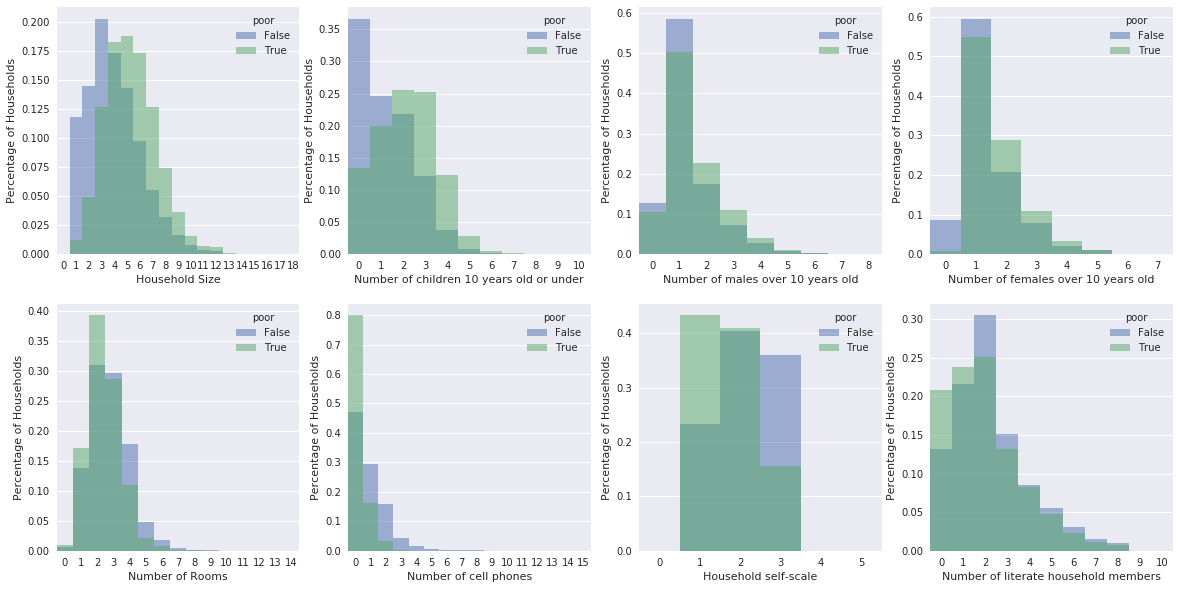

In [19]:
# Compare poor vs non-poor numeric features
#   We have 8 numeric features, so we make a 2x3 grid to plot them
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plot_numeric_hist(mwi_hhold, 
                  'der_hhsize', 
                  'Household Size', 
                  ax=axes[0][0])
plot_numeric_hist(mwi_hhold, 
                  'der_nchild10under', 
                  'Number of children 10 years old or under', 
                  ax=axes[0][1])
plot_numeric_hist(mwi_hhold, 
                  'der_nmalesover10', 
                  'Number of males over 10 years old', 
                  ax=axes[0][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nfemalesover10', 
                  'Number of females over 10 years old', 
                  ax=axes[0][3])
plot_numeric_hist(mwi_hhold, 
                  'hld_rooms', 
                  'Number of Rooms', 
                  ax=axes[1][0])
plot_numeric_hist(mwi_hhold, 
                  'hld_nbcellpho', 
                  'Number of cell phones', 
                  ax=axes[1][1])
plot_numeric_hist(mwi_hhold, 
                  'hld_selfscale', 
                  'Household self-scale', 
                  ax=axes[1][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nliterate', 
                  'Number of literate household members', 
                  ax=axes[1][3])

plt.show()

From the histograms, we can see that there is not a lot of distinct separation in the distribution of responses between poor and non-poor, except for possibly in the household size and the number of children under 10 years old. We can expect these features to have more of an impact as predictors. However, note that the number of children under 10 is just a subset of the household size, so we may only need to keep one of these features in our classifiers.

Let's also look at which consumables appear most in the dataset. There are 212 consumables in the Malawi survey. We would like to get a better understanding of which ones are most important for predicting if a household is poor and possibly reduce this number to 50 or less. 

First, we'll just look to see which consumables had the greatest number of "Yes" responses.

In [20]:
# Filter consumables and group by poor/non-poor
consumable_columns = [x for x in mwi_hhold.columns if x.startswith('cons_')]
consumables = (mwi_hhold.groupby('poor')[consumable_columns]
                        .sum()
                        .T)

consumables.columns = ['Non_poor', 'Poor']
consumables['total'] = consumables.sum(axis=1)
consumables['percent'] = consumables.total / mwi_hhold.shape[0]

# Match up the consumable names for readability
get_consumable_name = lambda x: mwi_hhold_questions[x.split('__')[0]]
consumables.index = consumables.index.map(get_consumable_name)

# Display the top 10 most common consumables
consumables.sort_values('percent', ascending=False).head(10)

,Non_poor,Poor,total,percent
Salt,6677.0,5471.0,12148.0,0.992159
"Milling fees, grain",6223.0,5238.0,11461.0,0.936050
Bar soap (body soap or clothes soap),6387.0,5027.0,11414.0,0.932212
Tomato,6105.0,4197.0,10302.0,0.841392
Matches,5810.0,4411.0,10221.0,0.834776
"Glycerine, Vaseline, skin creams",5888.0,4207.0,10095.0,0.824485
Dried fish,4798.0,3244.0,8042.0,0.656811
Cooking oil,5396.0,2571.0,7967.0,0.650686
Nkhwani,4316.0,3613.0,7929.0,0.647582
Sugar,5516.0,2393.0,7909.0,0.645949


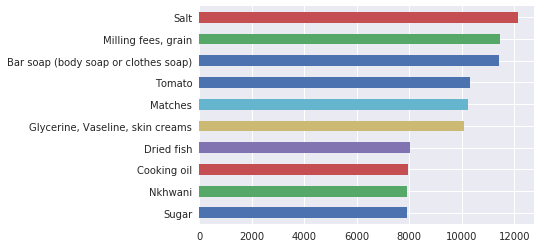

In [21]:
# Plot the top 10 most common consumables
(consumables.total
            .sort_values(ascending=False)
            .head(10)
            .sort_values(ascending=True).plot.barh());

The consumables that appear most often may simply be those that are common to both poor and non-poor households and may not be a great predictor of poverty. For instance, over 90% of households reported purchasing salt, grain, and bar soap regardless of their poverty status. 

What is potentially more interesting is consumables that appear more frequently in non-poor households compared to poor. If there is a large difference, this item may be an indicator of the household's poverty status.

In [22]:
consumables['difference'] = (consumables.Non_poor - consumables.Poor) / consumables.total

# Display the top 20 most common consumables
display(consumables.sort_values('difference', ascending=False).head(20))

,Non_poor,Poor,total,percent,difference
Breakfast cereal,48.0,0.0,48.0,0.003920,1.000000
Night's lodging in rest house or hotel,62.0,0.0,62.0,0.005064,1.000000
Mortgage - regular payment to purchase house,5.0,0.0,5.0,0.000408,1.000000
Bottled water,74.0,0.0,74.0,0.006044,1.000000
Yoghurt,151.0,0.0,151.0,0.012333,1.000000
Butter,40.0,0.0,40.0,0.003267,1.000000
Tomato sauce (bottle),74.0,0.0,74.0,0.006044,1.000000
"Jam, jelly",32.0,0.0,32.0,0.002614,1.000000
"Cocoa, millo",131.0,0.0,131.0,0.010699,1.000000
Cheese,19.0,0.0,19.0,0.001552,1.000000


The list above is more interesting. In the majority of survey responses, the households reporting that they purchased these items were not poor.

### Indonesia Exploration

Now let's look at the Indonesia data, starting with a comparison of the numeric features.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

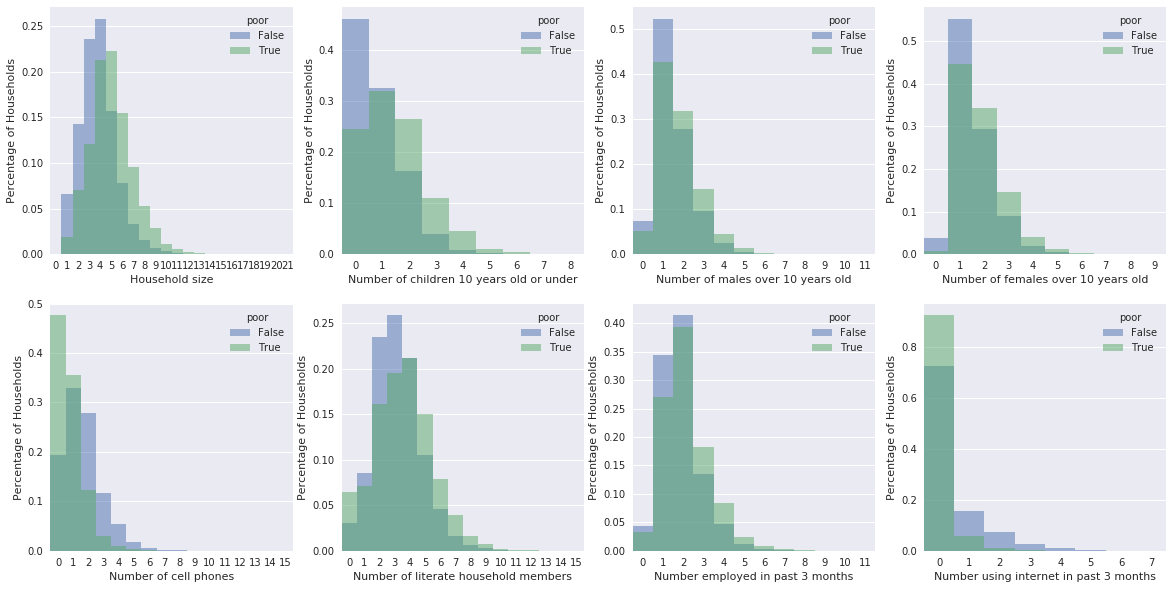

In [23]:
# Compare poor vs non-poor numeric features
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plot_numeric_hist(idn_hhold, 
                  'der_hhsize', 
                  'Household size',
                  ax=axes[0][0])
plot_numeric_hist(idn_hhold, 
                  'der_nchild10under',
                  'Number of children 10 years old or under',
                  ax=axes[0][1])
plot_numeric_hist(idn_hhold, 
                  'der_nmalesover10',
                  'Number of males over 10 years old',
                  ax=axes[0][2])
plot_numeric_hist(idn_hhold, 
                  'der_nfemalesover10', 
                  'Number of females over 10 years old', 
                  ax=axes[0][3])
plot_numeric_hist(idn_hhold, 
                  'hld_nbcell',
                  'Number of cell phones',
                  ax=axes[1][0])
plot_numeric_hist(idn_hhold,
                  'der_nliterate', 
                  'Number of literate household members',
                  ax=axes[1][1])
plot_numeric_hist(idn_hhold,
                  'der_nemployedpast3mo', 
                  'Number employed in past 3 months', 
                  ax=axes[1][2])
plot_numeric_hist(idn_hhold,
                  'der_ninternetpast3mo',
                  'Number using internet in past 3 months',
                  ax=axes[1][3])

plt.show()

As with the Malawi data, there is not much separation in the distribution of the numeric features in the Indonesia dataset, except for possibly the household size and number of children.

Now let's look at the consumables in the Indonesia data:

In [24]:
# Filter consumables and group by poor/non-poor
consumable_columns = [x for x in idn_hhold.columns if x.startswith('cons_')]
consumables = (idn_hhold.groupby('poor')[consumable_columns]
                        .sum()
                        .T)

consumables.columns = ['Non_poor', 'Poor']
consumables['total'] = consumables.sum(axis=1)
consumables['percent'] = consumables.total / idn_hhold.shape[0]

# Match up the consumable names for readability
get_consumable_name = lambda x: idn_hhold_questions[x.split('__')[0]]
consumables.index = consumables.index.map(get_consumable_name)

# Display the top 10 most common consumables
consumables.sort_values('percent', ascending=False).head(10)

,Non_poor,Poor,total,percent
"Bathing soap, toothpaste, toothbrush, and shampoo",63871.0,6253.0,70124.0,0.989851
"Rice (local, super quality, import)",62743.0,5915.0,68658.0,0.969157
"Laundry soap (bars, powders, creams, and liquid)",61435.0,5985.0,67420.0,0.951682
Salt,60881.0,6159.0,67040.0,0.946318
Onion,58607.0,5401.0,64008.0,0.903519
"In the case of own / rent-free house, an estimated monthly rent",57665.0,6238.0,63903.0,0.902037
Cane sugar,57942.0,5098.0,63040.0,0.889855
"Others (batteries, storage batteries, matches,..)",57530.0,5460.0,62990.0,0.889149
Garlic,53702.0,4605.0,58307.0,0.823045
Cosmetic articles and sanitary napkin,52703.0,4384.0,57087.0,0.805824


This list is different than the results for Malawi, but we see some similarities, such as purchase of Salt and soap for nearly all the households. Let's look at differences as well to see if there are any particularly revealing responses.

In [25]:
consumables['difference'] = (consumables.Non_poor - consumables.Poor) / consumables.total

# Display the top 10 most common consumables
display(consumables.sort_values('difference', ascending=False).head(20))

,Non_poor,Poor,total,percent,difference
Canned fruit,26.0,0.0,26.0,0.000367,1.000000
Wine,46.0,0.0,46.0,0.000649,1.000000
Beer,174.0,0.0,174.0,0.002456,1.000000
Cheese,204.0,0.0,204.0,0.002880,1.000000
Canned meat,79.0,0.0,79.0,0.001115,1.000000
Shredded fried meat,139.0,0.0,139.0,0.001962,1.000000
Fried chips,714.0,2.0,716.0,0.010107,0.994413
Financial service charge,3360.0,22.0,3382.0,0.047739,0.986990
Syrup,1291.0,9.0,1300.0,0.018350,0.986154
"Domestic servant, security, and driver (salary or wages)",3193.0,23.0,3216.0,0.045396,0.985697


Once again, there are several consumables that are only present in responses from non-poor households, such as fried chips, beer, and cheese. 

One thing to recall is that there are much fewer "poor" households in this dataset relative to "non-poor" than what we have with Malawi, so simply looking at the difference in responses in this way may not be as informative for predicing poverty in Indonesia. We will discuss how to deal with an unbalanced dataset like this in the Indonesia notebooks for each algorithm.

## Create Train/Test Split and Save Data <a class="anchor" id="save-data"></a>

As a final step, we want to split the data into training and test sets which will be used by all of the algorithms. We'll reserve 25% of the data as a test set. 

Each country will have three associated csv files: train, test, and metadata

In [26]:
# Split Malawi data and Indonesia data
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)
idn_train, idn_test = train_test_split(idn_hhold,
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=idn_hhold.poor)

# Save data to files
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = load_data.get_country_filepaths('mwi')
mwi_train.to_pickle(TRAIN_PATH)
mwi_test.to_pickle(TEST_PATH)
with open(QUESTIONS_PATH, 'w') as fp:
    json.dump(mwi_hhold_questions, fp)

TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = load_data.get_country_filepaths('idn')
idn_train.to_pickle(TRAIN_PATH)
idn_test.to_pickle(TEST_PATH)
with open(QUESTIONS_PATH, 'w') as fp:
    json.dump(idn_hhold_questions, fp)
    